## Подготовка к анализу

In [271]:
# Импортируем основные библиотеки
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [272]:
# Загружаем данные
df = pd.read_csv('gallery_value.csv', sep=';', encoding='utf-8')

### Кластеризация методом k-means

**Коротко о методе** \
K-means — это алгоритм, который автоматически разделяет данные на группы (кластеры) на основе их схожести. \
Каждая группа имеет "центр" (центроид), который представляет собой среднее значение всех точек в этой группе. \
Алгоритм пересчитывает расстояния от каждой точки до центроидов и перемещает точки в ближайший кластер, после чего центроиды обновляются, и процесс повторяется до стабилизации.

<img src="clustering.gif" width="500">

*Визуализация алгоритма*

In [273]:
# Добавляем библиотеку с алгоритмом кластеризации
from sklearn.cluster import KMeans

# Выделяем признак для кластеризации (выручка)
X = df[["Общая выручка"]]

#### Выясним оптимальное количество кластеров

C:\Users\Huawei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Huawei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Huawei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Huawei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

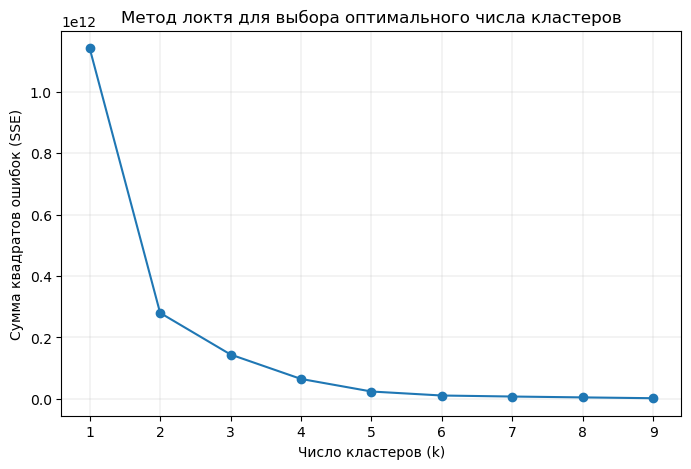

In [274]:
sse = []  # Сумма квадратов ошибок
k_values = range(1, 10)  # Проверяем k от 1 до 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # inertia_ содержит SSE

# Визуализация метода локтя
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker="o")
plt.xlabel("Число кластеров (k)")
plt.ylabel("Сумма квадратов ошибок (SSE)")
plt.title("Метод локтя для выбора оптимального числа кластеров")
plt.grid(True, which='both', axis='both', linestyle='-', linewidth=0.2)
plt.show()

Учитывая требования бизнеса по небольшому количеству кластеров и принмая во внимание результаты метода локтя, оптимальным количеством кластеров будет число 3

In [275]:
optimal_k = 3

#### Проводим кластеризацию

In [276]:
# Применяем k-means с k=3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["Кластер"] = kmeans.fit_predict(X)

# Посмотрим координаты центроидов
print("Центроиды:", kmeans.cluster_centers_)

C:\Users\Huawei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Huawei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Центроиды: [[ 494909.        ]
 [ 162936.17647059]
 [1011280.        ]]


#### Сортируем номера кластеров по уменьшению выручки

In [277]:
# Вычисляем среднюю выручку для каждого кластера
cluster_means = df.groupby("Кластер")["Общая выручка"].mean()

# Сортируем кластеры по средней выручке (от большего к меньшему)
sorted_clusters = cluster_means.sort_values(ascending=False).index

# Создаем словарь для переприсвоения номеров кластеров
cluster_remap = {old: new for new, old in enumerate(sorted_clusters)}

# Применяем переприсвоение номеров кластеров
df["Кластер"] = df["Кластер"].map(cluster_remap)

#### Визуализируем результат с помощью точечной диаграммы

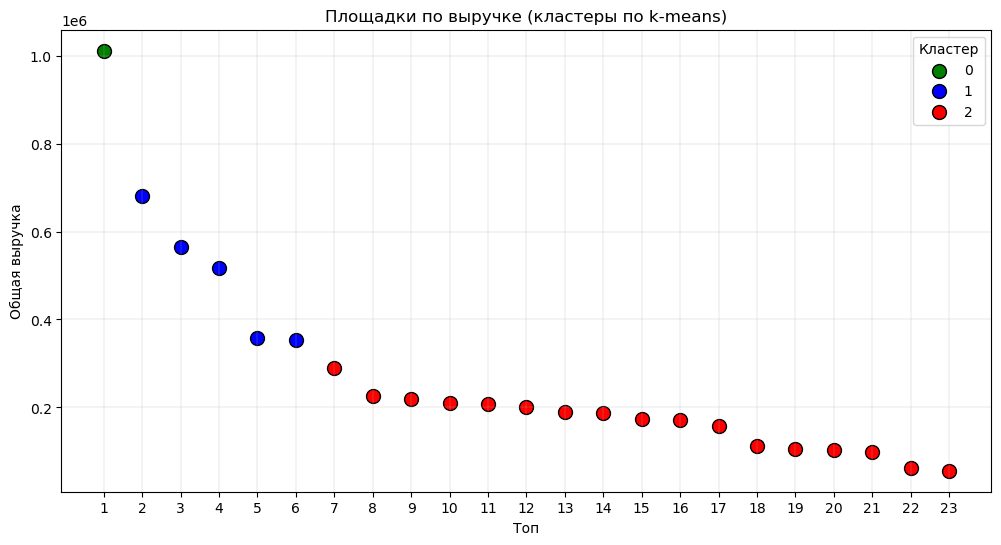

In [278]:
# Визуализация: точечная диаграмма
plt.figure(figsize=(12, 6))
colors = {0: "green", 1: "blue", 2: "red"}

# Создаем категориальную ось X
x = np.arange(len(df))  # Позиции для каждой площадки
plt.xticks(x, df["Топ"])  # Подписи для оси X

# Рисуем точки для каждой группы
for group, color in colors.items():
    group_data = df[df["Кластер"] == group]
    x_positions = x[df["Кластер"] == group]
    plt.scatter(x_positions, group_data["Общая выручка"], 
                color=color, label=group, s=100, edgecolor='black')

# Настройки графика
plt.xlabel("Топ")
plt.ylabel("Общая выручка")
plt.title("Площадки по выручке (кластеры по k-means)")
plt.legend(title="Кластер")
plt.grid(True, which='both', axis='both', linestyle='-', linewidth=0.2)

# Добавляем сетку с шагом 1 по оси X
plt.gca().set_xticks(x, minor=True)
plt.gca().xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)

plt.show()

In [279]:
# Также посмотрим на таблицу
gallery_cluster_prep = df[["Топ", "Площадка", "Общая выручка", "Кластер"]]
print(gallery_cluster_prep)

    Топ         Площадка  Общая выручка  Кластер
0     1           Плэнер        1011280        0
1     2             Этюд         681160        1
2     3         Мольберт         564805        1
3     4      Перспектива         518060        1
4     5          Пастель         357960        1
5     6            Холод         352560        1
6     7          Колорит         290515        2
7     8              Арт         225300        2
8     9        Перфоманс         218870        2
9    10            Ветер         209190        2
10   11            Кисть         207795        2
11   12       Технология         200640        2
12   13          Монолог         188840        2
13   14             Ритм         187015        2
14   15        Партитура         173600        2
15   16            Афиша         172325        2
16   17          Гризайл         157805        2
17   18       Постмодерн         112365        2
18   19          Палитра         105460        2
19   20  Новое искус

#### Отдаем результат бизнесу

По результатам кластеризации видно, что большинство галерей относятся к группе с низкой выручкой. \
Вероятно, что количество кластеров задано недостаточное, и их стоит увеличить для более сбалансированного распределения данных.

В качестве альтернативы можно рассмотреть другие методы группировки. Например, разделение выручки по процентилям. \
Такой подход более прозрачен и интуитивно понятен, что упрощает интерпретацию результатов.

Тем не менее, менеджмент утвердил первоначальный вариант с небольшими корректировками, поэтому в дашборде будет использована кластеризация методом k-means.

In [280]:
# В соответсвии с бизнес-правилами назовем полученные кластеры

# Создаем словарь для замены
cluster_to_evaluation = {0: "Высокая", 1: "Средняя", 2: "Низкая"}

# Добавляем новый столбец
df["Группа по выручке"] = df["Кластер"].map(cluster_to_evaluation)

# Добавляем столбец в таблицу
gallery_cluster_fin = df[["Топ", "Площадка", "Общая выручка", "Кластер", "Группа по выручке"]]

print(gallery_cluster_fin)

    Топ         Площадка  Общая выручка  Кластер Группа по выручке
0     1           Плэнер        1011280        0           Высокая
1     2             Этюд         681160        1           Средняя
2     3         Мольберт         564805        1           Средняя
3     4      Перспектива         518060        1           Средняя
4     5          Пастель         357960        1           Средняя
5     6            Холод         352560        1           Средняя
6     7          Колорит         290515        2            Низкая
7     8              Арт         225300        2            Низкая
8     9        Перфоманс         218870        2            Низкая
9    10            Ветер         209190        2            Низкая
10   11            Кисть         207795        2            Низкая
11   12       Технология         200640        2            Низкая
12   13          Монолог         188840        2            Низкая
13   14             Ритм         187015        2            Ни

In [281]:
# Скачиваем в csv
gallery_cluster.to_csv('gallery_cluster_fin.csv', sep=',', index=False, encoding='utf-8')